In [1]:
%run pretrained-model.ipynb

CUDA Available:  True
Test Error: 
 Accuracy: 98.1%, Avg loss: 0.239305 



In [2]:
# FGSM attack code
def fgsm_attack(image, alpha, data_grad):
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + alpha*data_grad.sign()
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [3]:
def mi_fgsm_attack(data, target, alpha, T, mu):
    perturbed_image = data
    
    g = 0
    
    for i in range(T):
        data.requires_grad = True

        output = model(data)
        if output.max(1, keepdim=True)[1].item() != target.item(): continue # only test on correctly predicted data
            
        loss = F.nll_loss(output, target)
        
        model.zero_grad()
        loss.backward()
        
        data_grad = data.grad.data
        
        g += data_grad * mu
        perturbed_image = fgsm_attack(perturbed_image, alpha, g)
    
    return perturbed_image

In [4]:
def test( model, device, test_loader, alpha, T, mu ):

    # Accuracy counter
    top1_correct = 0
    top5_correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:
        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Call FGSM Attack
        perturbed_data = mi_fgsm_attack(data, target, alpha, T, mu)
        
        # Re-classify the perturbed image
        output = model(perturbed_data)
        final_pred_top1 = torch.topk(output, 1).indices # get the index of the max log-probability
        final_pred_top5 = torch.topk(output, 5).indices # get the index of the max log-probability
        
        if final_pred_top1.item() == target.item():
            top1_correct += 1
        if target.item() in final_pred_top5:
            top5_correct += 1
        
        # Check for success
        if final_pred_top1.item() != target.item():
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (final_pred_top1.item(), adv_ex) )
        
    # Calculate final accuracy for this epsilon
    top1_accuracy = top1_correct/float(len(test_loader))
    top5_accuracy = top5_correct/float(len(test_loader))
    
    # Return the accuracy and an adversarial example
    return top1_accuracy, top5_accuracy, adv_examples

In [5]:
top1_accuracy = []
top5_accuracy = []
examples = []
iterations = [1, 2, 3, 4, 5]
alpha = 0.1
mu = 0.5
# Run test for each epsilon
for T in iterations:
    acc1, acc5, ex = test(model, device, test_loader, alpha, T, mu)
    top1_accuracy.append(acc1)
    top5_accuracy.append(acc5)
    examples.append(ex)

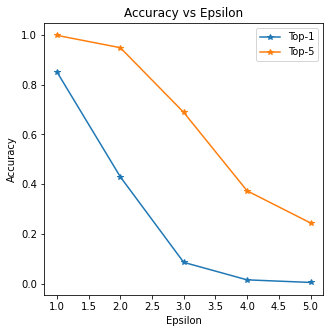

In [6]:
plt.figure(figsize=(5,5))
plt.plot(iterations, top1_accuracy, "*-", label="Top-1")
plt.plot(iterations, top5_accuracy, "*-", label="Top-5")
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.legend(loc="upper right")
plt.show()

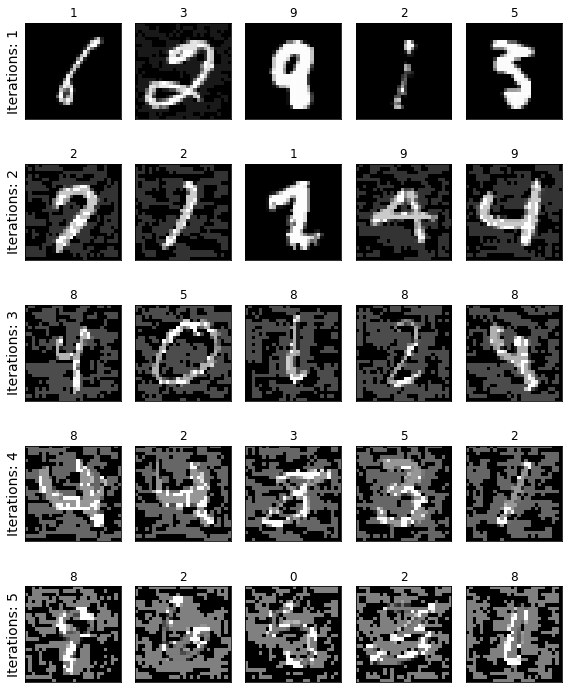

In [7]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(iterations)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(iterations),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Iterations: {}".format(iterations[i]), fontsize=14)
        adv,example = examples[i][j]
        plt.title("{}".format(adv))
        plt.imshow(example, cmap="gray")
plt.tight_layout()
plt.show()